In [1]:
!pip install PyDrive
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from skimage import color
from pathlib import Path
import tensorflow as tf
from skimage.transform import resize, rescale, rotate, setup, warp, AffineTransform
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import cv2
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [4]:
#Define Paths
data_path = Path('/content/drive/My Drive/dataset/chestdata/chest_xray')         # Define path for data
def path_produce(premiere_path,destination_path):
  x=""
  y=""
  z=""
  x= premiere_path/destination_path
  y= x/'NORMAL'
  z= x/'PNEUMONIA' 
  return x,y,z

train_path, normal_train_path, pneumonia_train_path  =  path_produce(data_path, 'train')               # Define paths for train set data, normal and pneumonia (train) set data
validation_path, normal_validation_path, pneumonia_validation_path  =  path_produce(data_path, 'val')  # Define paths for validation set data, normal and pneumonia (Validation) set data
test_path, normal_test_path, pneumonia_test_path  =  path_produce(data_path, 'test')                   # Define paths for test set data, normal and pneumonia (test) set data


def get_images(normal_images_path,pneumonia_images_path): 
  return normal_images_path.glob('*.jpeg') ,pneumonia_images_path.glob('*.jpeg') 

normal_train_data, pneumonia_train_data  = get_images(normal_train_path, pneumonia_train_path)                     #Get all normal and pneumonia images of the train set
normal_validation_data, pneumonia_validation_data  = get_images(normal_validation_path, pneumonia_validation_path) #Get all normal and pneumonia images of the validation set
normal_test_data, pneumonia_test_data  = get_images(normal_test_path, pneumonia_test_path)                         #Get all normal and pneumonia images of the test set

In [5]:
# labeling of datasets
def labeling_images(n_data,p_data):
  normal_data = pd.DataFrame(n_data, columns=['X_rayImage'],index=None)
  normal_data['pneumonia'] = '0'
  pneumonia_data = pd.DataFrame(p_data , columns=['X_rayImage'],index=None)
  pneumonia_data['pneumonia'] = '1'
  d = [normal_data,pneumonia_data]
  data = pd.concat(d)
  return  data, normal_data, pneumonia_data

print(normal_train_data)
train_data, normal_train_data, pneumonia_train_data = labeling_images(normal_train_data,pneumonia_train_data)

validation_data, normal_validation_data, pneumonia_validation_data= labeling_images(normal_validation_data,pneumonia_validation_data)

test_data,normal_test_data, pneumonia_test_data = labeling_images(normal_test_data,pneumonia_test_data)

<generator object Path.glob at 0x7f59caa8a2d0>


In [6]:
# shuffle datasets
train_data = train_data.sample(frac=1.).reset_index(drop=True)
validation_data = validation_data.sample(frac=1.).reset_index(drop=True)
test_data = test_data.sample(frac=1.).reset_index(drop=True)

#Print first five rows of train set
train_data.head()

,X_rayImage,pneumonia
0,/content/drive/My Drive/dataset/chestdata/ches...,1
1,/content/drive/My Drive/dataset/chestdata/ches...,1
2,/content/drive/My Drive/dataset/chestdata/ches...,0
3,/content/drive/My Drive/dataset/chestdata/ches...,1
4,/content/drive/My Drive/dataset/chestdata/ches...,0


In [7]:
# Find number of data in each data set
print("Before preprocessing:")
print("train_data.shape", train_data.shape,"test_data.shape", test_data.shape, "validation_data.shape", validation_data.shape)
d = [train_data,validation_data]
data= pd.concat(d)
X = data.X_rayImage;
y = data.pneumonia;


# Combine validation dataset and train dataset, and split the combined data set in two data sets: 90% data for train dataset and 10% data for validation data set
# Reason for combining these datasets: validation dataset is too small

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=1)
df1 = {'X_rayImage': X_train, 'pneumonia': y_train}
train_data = pd.DataFrame(df1,index=None)

df2 = {'X_rayImage': X_val, 'pneumonia': y_val}
validation_data = pd.DataFrame(df2,index=None)
train_data.head()
print("After preprocessing:")
print("train_data.shape", train_data.shape,"test_data.shape", test_data.shape, "validation_data.shape", validation_data.shape)


Before preprocessing:
train_data.shape (5216, 2) test_data.shape (624, 2) validation_data.shape (16, 2)
After preprocessing:
train_data.shape (4708, 2) test_data.shape (624, 2) validation_data.shape (524, 2)


Number of pneumonia and normal cases in train data:
 1    3502
0    1206
Name: pneumonia, dtype: int64


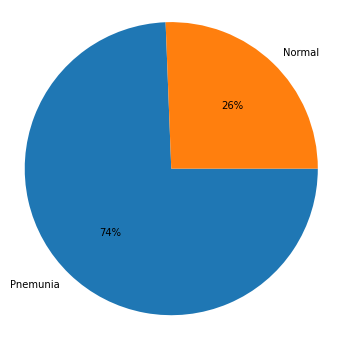

In [8]:
# Find number of each class in train set

train = train_data.pneumonia.value_counts()
print("Number of pneumonia and normal cases in train data:\n",train)
plt.figure(figsize=[6,6])
plt.pie(train, labels = ['Pnemunia','Normal'], counterclock=False,autopct='%1.0f%%');
plt.axis("square");

Number of pneumonia and normal cases in test data set:
 1    390
0    234
Name: pneumonia, dtype: int64


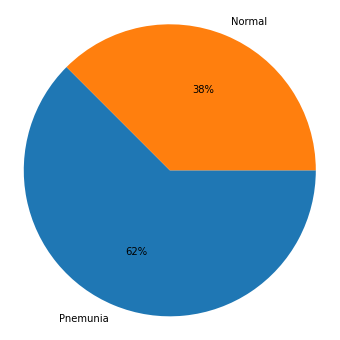

In [9]:
# Find number of each class in test set

test = test_data.pneumonia.value_counts()
print("Number of pneumonia and normal cases in test data set:\n",test)
plt.figure(figsize=[6,6])
plt.pie(test, labels = ['Pnemunia','Normal'], counterclock=False,autopct='%1.0f%%');
plt.axis("square");


Number of pneumonia and normal cases in validation data set:
 1    381
0    143
Name: pneumonia, dtype: int64


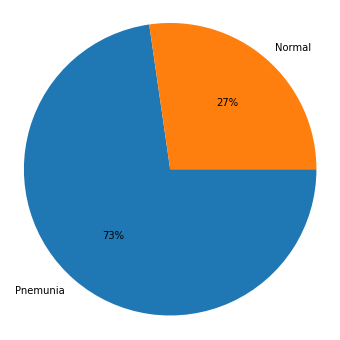

In [10]:
# Find number of each class in ]validation set

validation = validation_data.pneumonia.value_counts()
print("Number of pneumonia and normal cases in validation data set:\n",validation)
plt.figure(figsize=[6,6])
plt.pie(validation, labels = ['Pnemunia','Normal'], counterclock=False,autopct='%1.0f%%');
plt.axis("square");

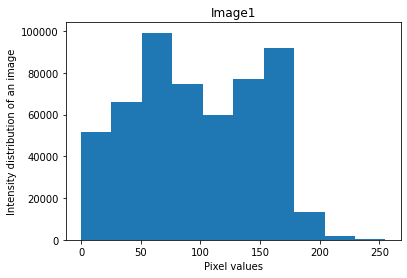

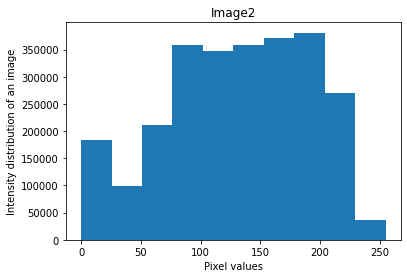

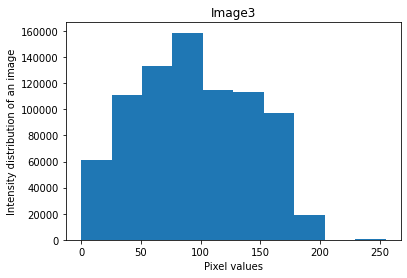

In [11]:
# plot intensity of pixels of 5 images
for i in range(3):
  plt.xlabel("Pixel values")
  plt.ylabel("Intensity distribution of an image")
  plt.title("Image{}".format(i+1))
  a = train_data['X_rayImage'].iloc[i]
  img = io.imread(a,1)
  plt.hist(img.ravel())
  plt.show()

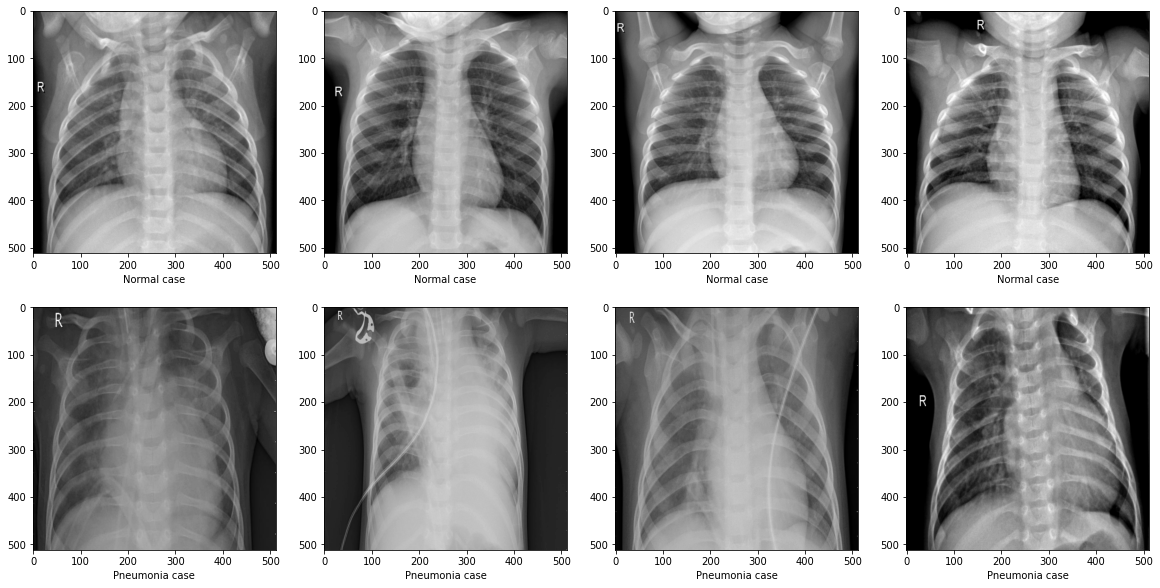

In [12]:
# Plot some of samples for Normal and Pneumonia classes

f,ax = plt.subplots(2,4, figsize=(20,10))
for i in range(4):
  img_normal = io.imread(normal_train_data['X_rayImage'].iloc[i])
  img_normal= resize(img_normal, (512,512))

  ax[0,i].imshow(img_normal,cmap='gray')
  ax[0,i].set_xlabel('Normal case')
  img_pneumonia = io.imread(pneumonia_train_data['X_rayImage'].iloc[i])
  img_pneumonia= resize(img_pneumonia, (512,512))

  ax[1,i].imshow(img_pneumonia,cmap='gray')
  ax[1,i].set_xlabel('Pneumonia case')


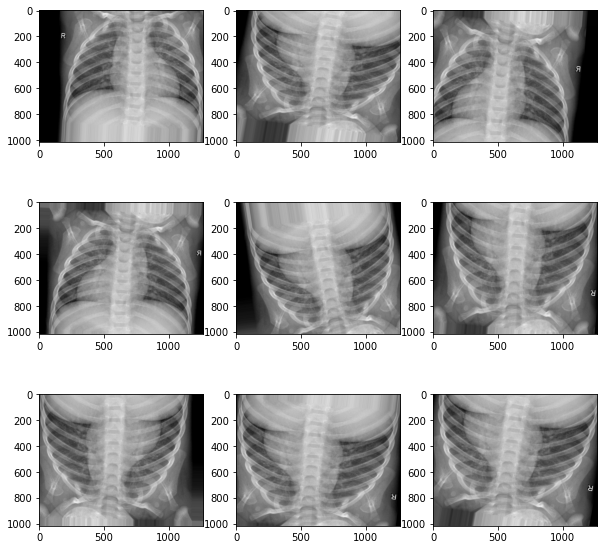

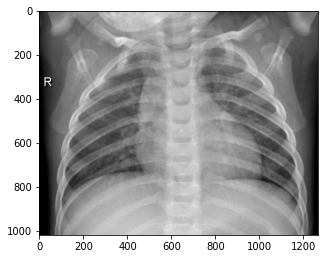

In [13]:
# Preprocessing object
#####Note: I have done rescaling  (rescale = 1/255), but here only to plot augmented images, I assumed rescale=1

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=10, width_shift_range=0.1,
    height_shift_range=0.1, brightness_range=None, shear_range=0.1, zoom_range=0.1,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=True,
    vertical_flip=True, rescale=1, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)
plt.figure(figsize=[10,10])
img = img_to_array(load_img(normal_train_data['X_rayImage'].iloc[0]))
augmented_images = expand_dims(img, 0)
it = datagen.flow(augmented_images, batch_size=1)
for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	plt.imshow(image)
plt.show()

img0 = load_img(normal_train_data['X_rayImage'].iloc[0])
plt.figure(figsize=[5,5])
plt.imshow(img0)

In [14]:
# Parameters
IMG_SIZE = 256  # Image size
BATCH_SIZE = 16

# Preprocessing object
idg = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=10, width_shift_range=0.1,
    height_shift_range=0.1, brightness_range=None, shear_range=0.1, zoom_range=0.1,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=True,
    vertical_flip=True, rescale=1/255.0, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

# Turn values to strings as a requirement for flow_from_dataframe
train_data['X_rayImage'] = train_data['X_rayImage'].astype("string")
validation_data['X_rayImage'] = validation_data['X_rayImage'].astype("string")
test_data['X_rayImage'] = test_data['X_rayImage'].astype("string")

# Create train generator
train_gen = idg.flow_from_dataframe(dataframe= train_data,
                                         directory=None, 
                                         x_col = 'X_rayImage',
                                         y_col = 'pneumonia',
                                         class_mode = 'binary',
                                         color_mode = 'grayscale',
                                         target_size = (IMG_SIZE,IMG_SIZE), 
                                         batch_size = BATCH_SIZE,
                                         shuffle = True,
                                         )

# Create test generator
validation_gen = idg.flow_from_dataframe(dataframe= validation_data, 
                                         directory=None, 
                                         x_col = 'X_rayImage',
                                         y_col = 'pneumonia',
                                         class_mode = 'binary',
                                         color_mode = 'grayscale',
                                         target_size = (IMG_SIZE,IMG_SIZE), 
                                         batch_size = BATCH_SIZE,
                                         shuffle = False,
                                         )

# Create test generator
test_gen = idg.flow_from_dataframe(dataframe= test_data, 
                                         directory=None, 
                                         x_col = 'X_rayImage',
                                         y_col = 'pneumonia',
                                         class_mode = 'binary',
                                         color_mode = 'grayscale',
                                         target_size = (IMG_SIZE,IMG_SIZE), 
                                         batch_size = BATCH_SIZE,
                                         shuffle = False,
                                         )

Found 4708 validated image filenames belonging to 2 classes.
Found 524 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [15]:
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

# Params
base_kernel_size = 32

# Initiate model
model = Sequential()

# Input layer
model.add(Input(shape=(IMG_SIZE,IMG_SIZE, 1)))

# Conv layers
# Block 1
model.add(Conv2D(base_kernel_size, 3, padding='same', activation='relu'))
model.add(Conv2D(base_kernel_size, 3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(2 * base_kernel_size, 3, padding='same', activation='relu'))
model.add(Conv2D(2 * base_kernel_size, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(4 * base_kernel_size, 3, padding='same', activation='relu'))
model.add(Conv2D(4 * base_kernel_size, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# # Block 4
# model.add(Conv2D(8 * base_kernel_size, 3, padding='same', activation='relu'))
# model.add(Conv2D(8 * base_kernel_size, 3, padding='same', activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# # Block 5
# model.add(Conv2D(16 * base_kernel_size, 3, padding='same', activation='relu'))
# model.add(Conv2D(16 * base_kernel_size, 3, padding='same', activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# FC layers
model.add(Flatten())

# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [16]:
# Metrics & Model Compilation
accuracy = tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
)

recall = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name='recall', dtype=None
)

precision = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name='precision', dtype=None
)

model.compile(loss='binary_crossentropy', 
              optimizer='Adamax', 
              metrics=[accuracy, recall, precision])

In [17]:
#Train Model
from keras.models import load_model

TRAINING = True
NUM_EPOCHS = 30
model_path = '/content/drive/MyDrive/Project_Colab/Pneumonia_detection/my_model.h5'

if TRAINING:
  class_weight = {0: 1, 1: 0.26}
  r = model.fit(train_gen, 
                epochs=NUM_EPOCHS, 
                validation_data=validation_gen,
                validation_steps=len(validation_gen),
                steps_per_epoch=None, 
                class_weight=class_weight)
   
  model.save(model_path)

else:

  # returns a compiled model
  # identical to the previous one
  model = load_model(model_path, compile=True)

Epoch 1/30
295/295 [==============================] - 522s 2s/step - loss: 0.1759 - binary_accuracy: 0.7740 - recall: 0.7296 - precision: 0.9562 - val_loss: 0.3392 - val_binary_accuracy: 0.8855 - val_recall: 0.8714 - val_precision: 0.9679
Epoch 2/30
295/295 [==============================] - 85s 289ms/step - loss: 0.1330 - binary_accuracy: 0.8634 - recall: 0.8364 - precision: 0.9767 - val_loss: 0.4390 - val_binary_accuracy: 0.8531 - val_recall: 0.8031 - val_precision: 0.9935
Epoch 3/30
295/295 [==============================] - 86s 290ms/step - loss: 0.1133 - binary_accuracy: 0.8855 - recall: 0.8638 - precision: 0.9799 - val_loss: 0.2775 - val_binary_accuracy: 0.8989 - val_recall: 0.8714 - val_precision: 0.9881
Epoch 4/30
295/295 [==============================] - 85s 287ms/step - loss: 0.1043 - binary_accuracy: 0.8906 - recall: 0.8712 - precision: 0.9795 - val_loss: 0.2652 - val_binary_accuracy: 0.8931 - val_recall: 0.8661 - val_precision: 0.9851
Epoch 5/30
295/295 [==================

Text(0.5, 0, 'epoch')

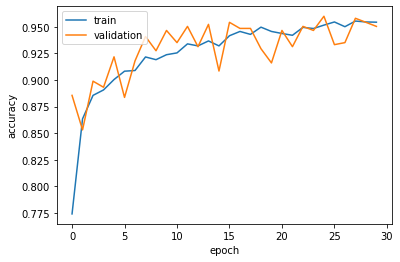

In [18]:
# Accuracy of train and validation set
plt.plot(r.history['binary_accuracy'])
plt.plot(r.history['val_binary_accuracy'])
plt.legend(['train', 'validation'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

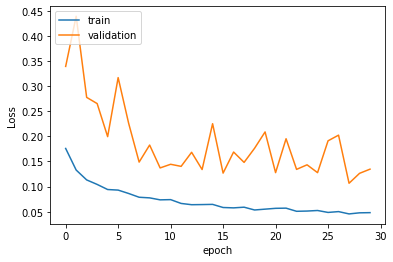

In [19]:
# loss of train and validation set
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.ylabel('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

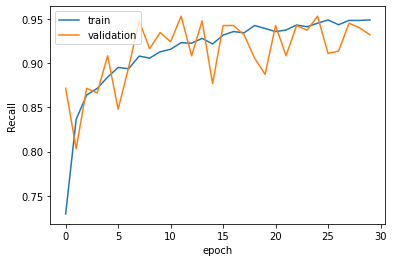

In [20]:
# Recall of train and validation set
plt.plot(r.history['recall'])
plt.plot(r.history['val_recall'])
plt.legend(['train', 'validation'], loc='upper left')
plt.ylabel('Recall')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

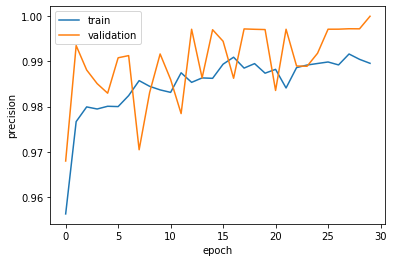

In [21]:
# Recall of train and validation set
plt.plot(r.history['precision'])
plt.plot(r.history['val_precision'])
plt.legend(['train', 'validation'], loc='upper left')
plt.ylabel('precision')
plt.xlabel('epoch')

In [22]:
model = load_model(model_path, compile=True)


In [23]:

num_test_batchs = len(iter(test_gen))
accuracy = tf.keras.metrics.BinaryAccuracy()

pred_list = []
label_list = []

for i in range(num_test_batchs):
  image, label = test_gen[i]
  out_model = model.predict(
    image, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False
    )
  pred_bool = tf.math.greater(out_model, 0.5, name=None)
  pred = tf.dtypes.cast(pred_bool, tf.int32)
  pred_list.append(pred)
  label_list.append(label)

In [24]:
# Flatten arrays
y_predict = np.asarray(pred_list).flatten()
y_test = np.asarray(label_list).flatten()

In [25]:
#Results
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score,precision_score,recall_score
print("confusion_matrix", confusion_matrix(y_test,y_predict))
print("Accuracy", accuracy_score(y_test, y_predict))
print("F1_Score", f1_score(y_test,y_predict, average = 'macro'))
print("Precision:",precision_score(y_test, y_predict,average='macro'))
print("recall",recall_score(y_test, y_predict,average='macro'))

confusion_matrix [[176  58]
 [ 10 380]]
Accuracy 0.8910256410256411
F1_Score 0.8779848171152518
Precision: 0.9069082339077921
recall 0.8632478632478633


In [26]:
#print summary of model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    